# Bayesian seats model for 2022 Australian Federal Election

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the data</a></span><ul class="toc-item"><li><span><a href="#Seat-history-data" data-toc-modified-id="Seat-history-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Seat history data</a></span></li><li><span><a href="#Polls-to-election-outcomes-data" data-toc-modified-id="Polls-to-election-outcomes-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Polls to election outcomes data</a></span></li><li><span><a href="#Election-outcomes-to-seats-data" data-toc-modified-id="Election-outcomes-to-seats-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Election outcomes to seats data</a></span></li><li><span><a href="#Most-recent-polling-data-and-its-aggregation" data-toc-modified-id="Most-recent-polling-data-and-its-aggregation-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Most recent polling data and its aggregation</a></span></li></ul></li><li><span><a href="#Stan-seats-and-house-outcomes-model" data-toc-modified-id="Stan-seats-and-house-outcomes-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Stan seats and house outcomes model</a></span></li><li><span><a href="#Visualise-results" data-toc-modified-id="Visualise-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualise results</a></span><ul class="toc-item"><li><span><a href="#Get-samples" data-toc-modified-id="Get-samples-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Get samples</a></span></li><li><span><a href="#Seats-won" data-toc-modified-id="Seats-won-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Seats won</a></span></li><li><span><a href="#House-outcome" data-toc-modified-id="House-outcome-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>House outcome</a></span></li></ul></li></ul></div>

## Python setup

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import arviz as az
import stan # install with pip - conda is problematic on the M1 MBP
import statsmodels.api as sm

# system imports
import pathlib
import math

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER

In [2]:
# enable pystan on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [3]:
# Package version numbers
print(f'Stan version: {stan.__version__}')
print(f'ArviZ version: {az.__version__}')
print(f'Statsmodels version: {sm.__version__}')

Stan version: 3.3.0
ArviZ version: 0.11.4
Statsmodels version: 0.13.1


In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

In [5]:
# Set to a Coalition 2pp estimate in the range 40 to 60 ...
MANUAL_TPP_OVERRIDE = 46.6 

## Get the data

Note: the data was produced by the "capture wiki election history data and preliminary charts" notebook.

### Seat history data

In [6]:
# data locations
SEAT_HISTORY_FILE = '../historical-data/Seat History.csv'

In [7]:
def fix_column_names(t: pd.DataFrame) -> pd.DataFrame:
    """Replace 'Unnamed' column names with ''."""
    
    replacements = {}
    for c in t.columns:
        if 'Unnamed' in c[1]:
            replacements[c[1]] = ''
    if replacements:
        t = t.rename(columns=replacements, level=1)
    return t

In [8]:
# Load historical elections data
seat_history = pd.read_csv(SEAT_HISTORY_FILE, header=[0, 1], 
                           index_col=0, parse_dates=[0], )
seat_history = fix_column_names(seat_history)
seat_history.index.dtype

dtype('<M8[ns]')

In [9]:
seat_history.columns

MultiIndex([(               'Primary vote',   'ALP'),
            (               'Primary vote',  'L+NP'),
            (               'Primary vote',  'Oth.'),
            (                   '2PP vote',   'ALP'),
            (                   '2PP vote',  'L+NP'),
            (                      'Seats',   'ALP'),
            (                      'Seats',  'L+NP'),
            (                      'Seats',  'Oth.'),
            (                      'Seats', 'Total'),
            ('Governing party at election',      ''),
            (            'Governing since',      ''),
            (             'PM at election',      ''),
            (              'Winning party',      ''),
            (                      'Notes',      ''),
            (             'log gov period',      ''),
            (                     'winner',      ''),
            (      'Govt 2pp votes margin',      ''),
            (          'Govt seats margin',      '')],
           )

In [10]:
seat_history['Proportion of others'] = (
    seat_history[('Seats',  'Oth.')] 
    / seat_history[('Seats', 'Total')]
)

In [11]:
# limit input data to recent history
HISTORY_START = 1969 # let's start with Don's party ...
seat_history = seat_history[seat_history.index.year >= HISTORY_START]

In [12]:
# limit autoregressive model of non-major party members to an even more recent period
seat_history['Row number'] = range(1, len(seat_history)+1)
AUTOREGRESS_FROM = 1993 # previous election non-zero, also subsequent also non-zero
assert(AUTOREGRESS_FROM >= HISTORY_START)
ar_from = seat_history.loc[seat_history.index.year == AUTOREGRESS_FROM, 'Row number'].values[0]
ar_from

11

In [13]:
len(seat_history)

20

### Polls to election outcomes data

In [14]:
p2e = pd.read_csv('../historical-data/poll-to-election-outcome.csv', header=0, index_col=0)
poll_slope, poll_intercept, poll_sigma = p2e[p2e.columns[0]].to_list()
p2e

,0
parameters,
poll_slope,1.012649
poll_intercept,0.130804
poll_sigma,1.085543


### Election outcomes to seats data

In [15]:
e2s = pd.read_csv('../historical-data/election-to-seats-outcome.csv', header=0, index_col=0)
conv_slope, conv_intercept, conv_sigma = e2s[e2s.columns[0]].to_list()
e2s

,0
parameters,
slope,3.360653
intercept,0.035437
sigma,0.062810


### Most recent polling data and its aggregation

In [16]:
# read in latest 2pp data 
# data produced by the notebook that captures the 
# wikipedia 2022 polling data and emitd LOWESS charts
tpp_df = pd.read_csv('../data/two_party_preferred.csv', parse_dates=['Mean Date'], index_col=0)
PERIOD = 100 # days
stop = tpp_df['Mean Date'].max()
start = stop - pd.Timedelta(days=PERIOD)
selected = tpp_df[tpp_df['Mean Date'] >= start]
lowess, period = common.get_lowess(selected['2pp vote L/NP'], selected['Mean Date'])
tpp = round(lowess[-1], 2)
tpp

45.51

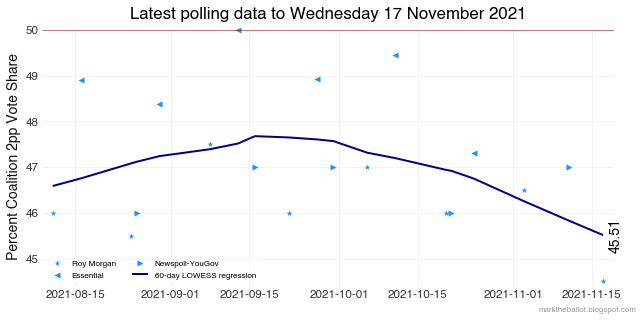

In [17]:
def plot_recent_lowess(lowess, selected):
    # Plot the polling data
    fix, ax = common.initiate_plot()
    markers = ['*', '<', '>', 'v', '^', 'd', 'x', 's', 'p']
    for i, firm in enumerate(selected['Brand'].unique()):
        firm_data = selected[selected['Brand'] == firm]
        ax.scatter(firm_data['Mean Date'], firm_data['2pp vote L/NP'],
                   color='dodgerblue', marker=markers[i], label=firm)
    
    # summarise polling data
    ax.plot(lowess.index, lowess, c='darkblue', lw=2,
            label=f'{period}-day LOWESS regression')

    # Plot a reference line
    ax.axhline(50, c='darkred', lw=0.5)
    
    # annotate end-point median to one devimal place ...
    ax.text(lowess.index[-1] + pd.Timedelta(days=1), 
        lowess.iloc[-1], 
        f'{round(lowess.iloc[-1], 2)}',
        rotation=90, ha='left', va='center',
        fontsize=14)
    
    ax.legend(loc='best', ncol=2)
    
    common.plot_finalise(ax, 
        title=f'Latest polling data to {lowess.index[-1].strftime("%A %d %B %Y")}', 
        ylabel='Percent Coalition 2pp Vote Share', 
        lfooter=None, rfooter='marktheballot.blogspot.com',
        location='../charts/')
        
plot_recent_lowess(lowess, selected)

In [18]:
# Manual Coalition TPP over-ride
if MANUAL_TPP_OVERRIDE:
    tpp = MANUAL_TPP_OVERRIDE

## Stan seats and house outcomes model

In [19]:
SEATS_NEXT_PARLIAMENT = 151
WIN_THRESHOLD = 75.5 # which will round up to 76 ...
seats_data = {

    'tpp': tpp, 
    
    'conv_slope': conv_slope,
    'conv_intercept': conv_intercept,
    'conv_sigma': conv_sigma,
    
    'poll_slope': poll_slope,
    'poll_intercept': poll_intercept,
    'poll_sigma': poll_sigma,
    
    'n_seats': SEATS_NEXT_PARLIAMENT,
    'n_history': len(seat_history),
    'win_threshold': WIN_THRESHOLD,
    'others': seat_history['Proportion of others'].values,
    'ar_from': ar_from,
}
tpp_footer = f'Coalition 2pp poll average = {seats_data["tpp"]} per cent'

In [20]:
seats_model = """
data {

    // input from the polling model
    real<lower=0,upper=100> tpp; 

    // input from the poll-to-election model
    real poll_slope;
    real poll_intercept;
    real<lower=0.000001> poll_sigma; // must be non-zero positive

    // input from the election-to-seats model
    real conv_slope;
    real conv_intercept;
    real<lower=0.000001> conv_sigma; // must be non-zero positive

    // inputs for this model
    int<lower=1> n_seats;     // number of seats in parliament next election
    real<lower=0,upper=n_seats> win_threshold; // account for rounding to ints
    int<lower=1> n_history;    // length of election history
    vector<lower=0,upper=1>[n_history] others;
    int<lower=1> ar_from;
}

parameters {
    // auto regressive, this year is much like last year
    real drift;
    real replication;
    real<lower=0.000001> s; // force half cauchy with lower bound
}

model {
    // priors on auto-regressive non-major-party seat proportion
    // --- this is not a great model in the circumstances
    drift ~ normal(0.0, 0.1);     // informative prior
    replication ~ normal(1, 0.1); // informative prior
    s ~ cauchy(0, 10);

    // limited autoregressive(1) model over recent data
    // for proportion of non-major-party seats
    others[ar_from:n_history] ~  
        normal(drift + (replication * others[(ar_from-1):(n_history-1)]), s);
}

generated quantities {

    // --- 2022 FORECAST ---

    // seats won by other parties
    real<lower=0,upper=n_seats> other_seats = 
        (drift + (replication * others[n_history])) * n_seats;

    // seats remaining available for the Coalition and Labor
    real<lower=0,upper=n_seats> available_seats = n_seats - other_seats;
    
    // Given current poll aggregate, what is the likely election 2pp result
    // Note: regression based on student_t, but prediction is from normal.
    real<lower=0, upper=1> e_tpp =
        normal_rng((poll_slope * tpp) + poll_intercept, poll_sigma) / 100;

    // Given the Coalition's TPP outcome, how many seats will the Coalition/Govt win?
    // Note: regression based on student_t, but prediction is from normal.
    real seats_forecast = 
        normal_rng(conv_slope * (e_tpp - (1 - e_tpp)) + conv_intercept, conv_sigma);
    
    real<lower=0,upper=n_seats> government_seats = 
        (available_seats / 2)
        + (seats_forecast * (available_seats / 2));

    // Labor seats = total seats - other seats - Coalition seats
    real<lower=0,upper=n_seats> opposition_seats = 
        (available_seats - government_seats);

    // How often does the Coalition government win the election?
    int<lower=0,upper=1> government_wins = government_seats > win_threshold ? 1 : 0;

    // How often does the Labor opposition win?
    int<lower=0,upper=1> opposition_wins = opposition_seats > win_threshold ? 1 : 0;
    
    // How often do we get a hung parliament?
    int<lower=0,upper=1> hung_parliament = 
        (government_wins == 0 && opposition_wins == 0) ? 1 : 0;
}
"""

In [21]:
posterior = stan.build(seats_model, data=seats_data)

# See note above about Stan warnings

Building: found in cache, done.


In [22]:
# This step takes between 1 and 2 minutes ...

SEATS_SAMPLES = 25_000
SEATS_CHAINS = 4
fit = posterior.sample(num_chains=SEATS_CHAINS, 
                       num_samples=SEATS_SAMPLES, )

# Note: Very occasionally, sampling produces one or two exceptions.
#       This should not be of too much concern, provided 
#       the total number is less than a handful. Not sure 
#       why, but the negative number exceptions result in 
#       garbage samples. We will fix this below.

Sampling:   0%
Sampling:  25% (26000/104000)
Sampling:  50% (52000/104000)
Sampling:  75% (78000/104000)
Sampling: 100% (104000/104000)
Sampling: 100% (104000/104000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!


In [23]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
drift,0.004,0.006,-0.008,0.015,0.000,0.000,59887.0,54996.0,1.0
replication,0.959,0.099,0.773,1.143,0.000,0.000,62439.0,62672.0,1.0
s,0.018,0.005,0.010,0.027,0.000,0.000,54591.0,51352.0,1.0
other_seats,6.390,0.917,4.714,8.173,0.004,0.003,72806.0,55041.0,1.0
available_seats,144.610,0.917,142.827,146.286,0.004,0.002,72806.0,55041.0,1.0
e_tpp,0.473,0.011,0.453,0.494,0.000,0.000,99183.0,99565.0,1.0
seats_forecast,-0.145,0.097,-0.330,0.035,0.000,0.000,99128.0,99422.0,1.0
government_seats,61.844,7.026,48.731,75.157,0.022,0.016,99072.0,99422.0,1.0
opposition_seats,82.765,7.035,69.473,95.912,0.022,0.016,98619.0,99008.0,1.0
government_wins,0.027,0.162,0.000,0.000,0.001,0.000,100890.0,100890.0,1.0


array([[<AxesSubplot:title={'center':'drift'}>,
        <AxesSubplot:title={'center':'drift'}>],
       [<AxesSubplot:title={'center':'replication'}>,
        <AxesSubplot:title={'center':'replication'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>],
       [<AxesSubplot:title={'center':'other_seats'}>,
        <AxesSubplot:title={'center':'other_seats'}>],
       [<AxesSubplot:title={'center':'government_seats'}>,
        <AxesSubplot:title={'center':'government_seats'}>],
       [<AxesSubplot:title={'center':'opposition_seats'}>,
        <AxesSubplot:title={'center':'opposition_seats'}>],
       [<AxesSubplot:title={'center':'government_wins'}>,
        <AxesSubplot:title={'center':'government_wins'}>],
       [<AxesSubplot:title={'center':'opposition_wins'}>,
        <AxesSubplot:title={'center':'opposition_wins'}>],
       [<AxesSubplot:title={'center':'hung_parliament'}>,
        <AxesSubplot:title={'center':'hung_parliament'}>]], dtype=

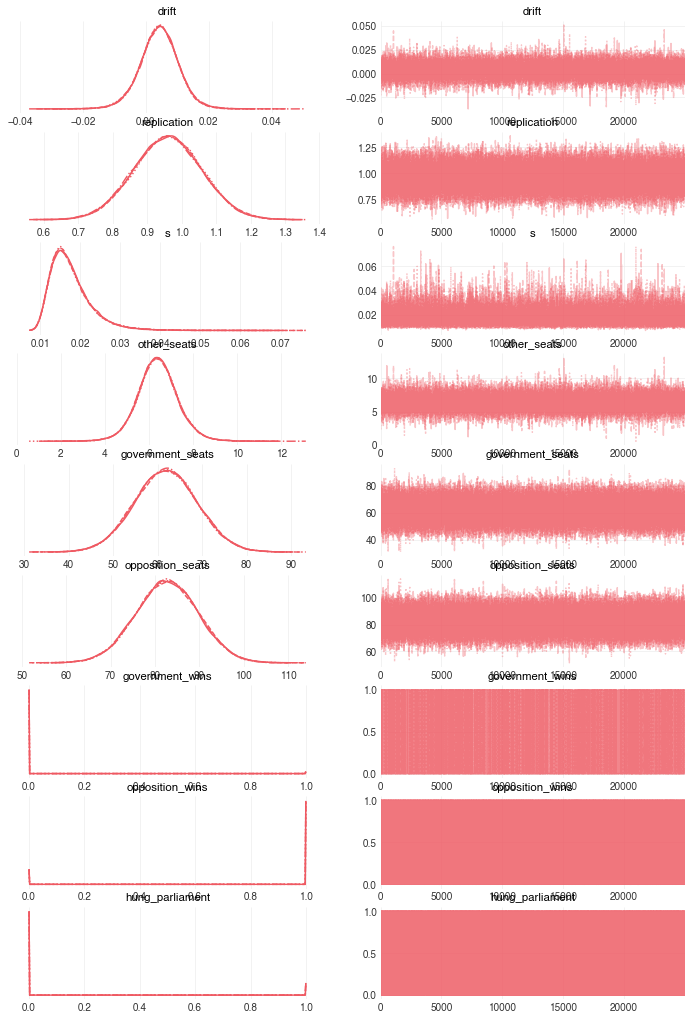

In [24]:
az.plot_trace(fit, var_names=['drift', 'replication', 's',
                              'other_seats', 'government_seats',
                              'opposition_seats', 'government_wins',
                              'opposition_wins', 'hung_parliament'])

## Visualise results

### Get samples

In [25]:
# Get our samples in a DataFrame
results_df = fit.to_frame()

# Let's drop any problematic samples that might have come about 
# as a result of any negative value exceptions (as noted above)
# Still not clear why this happens.
bad = results_df['government_seats'] == 0
if bad.sum() > 0:
    print(f'About to drop {bad.sum()} sample{"s" if bad.sum() > 1 else ""}')
results_df = results_df[~bad]
len(results_df) # remaining samples after removing the problematic ones (if any)

100000

In [26]:
# Check if the problem of bad samples has occurred too many times. 
#       I want it to occur in less than 1 in 10,000 samples.
THRESHOLD = 10_000
CHECK_TOO_MANY = int((SEATS_SAMPLES * SEATS_CHAINS) / THRESHOLD)
if bad.sum() > CHECK_TOO_MANY:
    print(f'Problem if deletions exceed this threshold: {CHECK_TOO_MANY}')
assert (SEATS_SAMPLES * SEATS_CHAINS) - CHECK_TOO_MANY < len(results_df)

### Seats won

In [27]:
def plot_seats_won(party, title, colour):
    sw = results_df[party].round(0).value_counts()
    sw = sw.sort_index() / sw.sum()
    outright_win = sw[sw.index > WIN_THRESHOLD].sum() / sw.sum()
    lfooter = f'Outright win probability = {round(outright_win, 5)}; {tpp_footer}'
    sw.index = sw.index.astype(int)
    _, ax = common.initiate_plot()
    ax.bar(x=sw.index, height=sw, color=colour)
    
    xlim = ax.get_xlim()
    if xlim[0] < WIN_THRESHOLD < xlim[1]:
        ax.axvline(WIN_THRESHOLD, lw=0.5, c='b')
    
    common.plot_finalise(ax, title,
                  xlabel='Number of seats won',
                  ylabel='Probability',
                  lfooter=lfooter, )

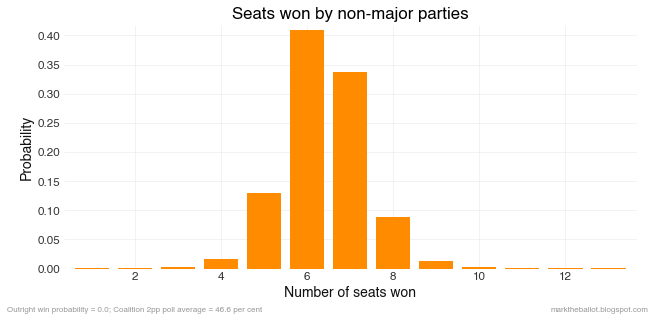

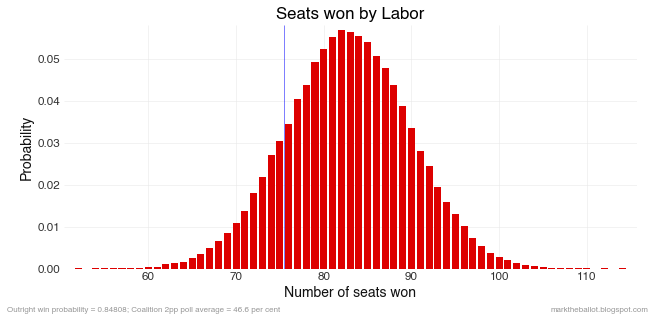

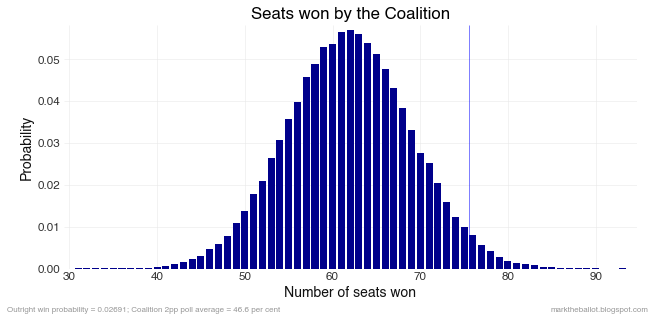

In [28]:
plot_seats_won('other_seats', 'Seats won by non-major parties', COLOR_OTHER)
plot_seats_won('opposition_seats', 'Seats won by Labor', COLOR_LABOR)
plot_seats_won('government_seats', 'Seats won by the Coalition', COLOR_COALITION)

### House outcome

parameters
Labour Wins Outright       0.84808
Hung Parliament            0.12501
Coalition Wins Outright    0.02691
dtype: float64


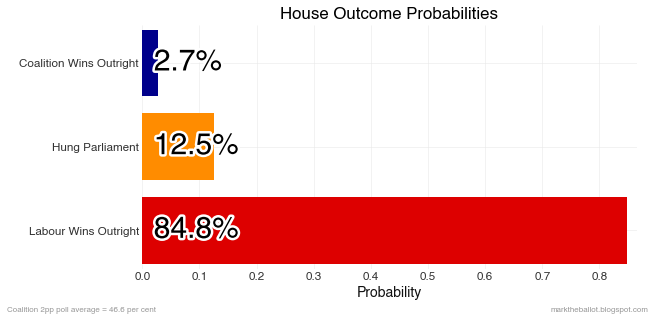

In [29]:
# probabilities for the types of house outcomes
def plot_house_probabilities():
    ho = results_df[['government_wins', 'opposition_wins', 'hung_parliament']].sum()
    renamer = {
        'opposition_wins': 'Labour Wins Outright',
        'hung_parliament': 'Hung Parliament',
        'government_wins': 'Coalition Wins Outright',
    }
    ho = ho.rename(index=renamer)
    order = list(renamer.values())
    ho = (ho / ho.sum())[order]
    print(ho) # more detail than the rounded version in the charts. 
    _, ax = common.initiate_plot()
    colors = [COLOR_LABOR, COLOR_OTHER, COLOR_COALITION, ]
    ax.barh(ho.index, ho, color=colors)
    for index, value in ho.iteritems():
        text = ax.text(x=0.02, y=index, s=f'{round(value*100, 1)}%', 
                fontsize=30, ha='left', va='center')
        text.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])
    common.plot_finalise(ax, 'House Outcome Probabilities',
                  ylabel=None,
                  xlabel='Probability',
                  lfooter=tpp_footer, 
                 )
    
plot_house_probabilities()

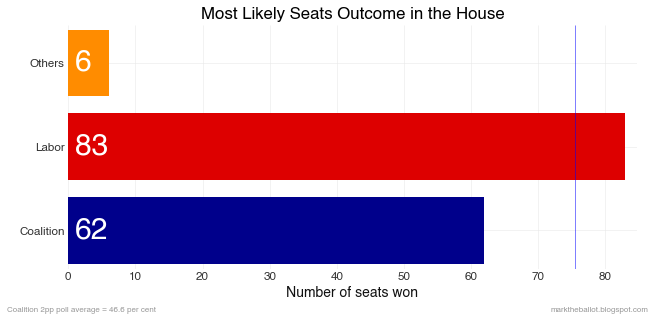

In [30]:
# Most likely house outcome
def plot_likely_house_seats_outcome():
    parties = ['government_seats', 'opposition_seats', 'other_seats']
    xparties = ['Coalition', 'Labor', 'Others']
    bar_dict = {}
    for p, x in zip(parties, xparties):
        bar_dict[x] = results_df[p].median()
    series = pd.Series(bar_dict)

    # check for jankie rounding errors
    rounded = series.round(0).astype(int)
    if rounded.sum() < SEATS_NEXT_PARLIAMENT:
        print('adjusting up')
        bless = (
            (series + 0.5)
            .apply(lambda a: math.modf(a)[0])
            .sort_values(ascending=False).index[0]
        )
        rounded[bless] = rounded[bless] + 1
    if rounded.sum() > SEATS_NEXT_PARLIAMENT:
        print('adjusting down')
        bless = (
            (series - 0.5)
            .apply(lambda a: math.modf(a)[0])
            .sort_values(ascending=True).index[0]
        )
        rounded[bless] = rounded[bless] - 1

    # plot
    fig, ax = common.initiate_plot()
    colors = [COLOR_COALITION, COLOR_LABOR, COLOR_OTHER]
    ax.barh(rounded.index, rounded, color=colors)
    ax.axvline(WIN_THRESHOLD, lw=0.5, c='b')

    for index, value in rounded.iteritems():
        ax.text(x=1, y=index, s=str(value), c='w', fontsize=30,
                ha='left', va='center')

    common.plot_finalise(ax, 
                  title='Most Likely Seats Outcome in the House',
                  xlabel='Number of seats won',
                  ylabel=None,
                  lfooter=tpp_footer)

plot_likely_house_seats_outcome()